# Predicting 2024 US Corn Yield

In [1]:
# Importing necessary libraries
import requests
import time
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.svm import SVR
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import ElasticNet
import lightgbm as lgb


## Download data

In [ ]:
# Reading the API key from a file
with open('API_key.txt') as f:
    api_key = f.read()

In [ ]:
# Setting up API parameters
API_KEY = api_key
BASE_URL = 'http://quickstats.nass.usda.gov/api/api_GET/'
OUTPUT_DIR = 'corn_yield_csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Select years for collection
START_YEAR = 1910
END_YEAR = 2024

for year in range(START_YEAR, END_YEAR + 1):
    params = {
        'key': API_KEY,
        'commodity_desc': 'CORN',
        'statisticcat_desc': 'YIELD',
        'unit_desc': 'BU / ACRE',
        'agg_level_desc': 'COUNTY',
        'year': year,
        'format': 'JSON'
    }

    try:
        print(f"Downloading data for year {year}...")
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        records = data.get('data', [])
        if not records:
            print(f"No data for {year}, next.")
            continue

        df = pd.DataFrame(records)

        # Saving the DataFrame to a CSV file
        csv_path = os.path.join(OUTPUT_DIR, f"corn_yield_{year}_county.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {csv_path} with {len(df)} record.")
        time.sleep(3)  

    except requests.exceptions.RequestException as e:
        print(f"Error for year {year}: {e}")
        time.sleep(5)

In [ ]:
# Assembling all CSV files into a single dataset
INPUT_DIR = 'corn_yield_csv'
OUTPUT_FILE = 'corn_yield_all_years_county.csv'

files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
dfs = []

for file in sorted(files):
    print(f"Loading {file}...")
    df = pd.read_csv(file)

    # clean the 'Value' column for consistency
    def clean_value(val):
        try:
            return float(str(val).replace(",", ""))
        except:
            return None
    df['Value'] = df['Value'].apply(clean_value)

    dfs.append(df)

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Dataset complete saved in '{OUTPUT_FILE}'.")
else:
    print("There are no files to assemble")

Loading corn_yield_csv\corn_yield_1910_county.csv...
Loading corn_yield_csv\corn_yield_1911_county.csv...
Loading corn_yield_csv\corn_yield_1912_county.csv...
Loading corn_yield_csv\corn_yield_1913_county.csv...
Loading corn_yield_csv\corn_yield_1914_county.csv...
Loading corn_yield_csv\corn_yield_1915_county.csv...
Loading corn_yield_csv\corn_yield_1916_county.csv...
Loading corn_yield_csv\corn_yield_1917_county.csv...
Loading corn_yield_csv\corn_yield_1918_county.csv...
Loading corn_yield_csv\corn_yield_1919_county.csv...
Loading corn_yield_csv\corn_yield_1920_county.csv...
Loading corn_yield_csv\corn_yield_1921_county.csv...
Loading corn_yield_csv\corn_yield_1922_county.csv...
Loading corn_yield_csv\corn_yield_1923_county.csv...
Loading corn_yield_csv\corn_yield_1924_county.csv...
Loading corn_yield_csv\corn_yield_1925_county.csv...
Loading corn_yield_csv\corn_yield_1926_county.csv...
Loading corn_yield_csv\corn_yield_1927_county.csv...
Loading corn_yield_csv\corn_yield_1928_county.

## Explorative analysis

### Yield Data

In [3]:
# Reading the assembled dataset
df = pd.read_csv('corn_yield_all_years_county.csv')

In [4]:
# Displaying basic statistics of the dataset
df.describe()

,region_desc,state_fips_code,country_code,state_ansi,week_ending,county_code,county_ansi,congr_district_code,end_code,begin_code,Value,watershed_desc,watershed_code,CV (%),year,zip_5,asd_code
count,0.0,221557.000000,221557.0,221557.000000,0.0,221557.000000,213879.000000,0.0,221557.0,221557.0,221557.000000,0.0,221557.0,7506.000000,221557.000000,0.0,221557.000000
mean,NaN,30.088032,9000.0,30.088032,NaN,124.446865,93.087353,NaN,0.0,0.0,81.044844,NaN,0.0,5.555622,1978.090415,NaN,49.885844
std,NaN,13.262452,0.0,13.262452,NaN,179.477601,70.645899,NaN,0.0,0.0,48.957053,NaN,0.0,4.511936,25.600817,NaN,25.498104
min,NaN,1.000000,9000.0,1.000000,NaN,1.000000,1.000000,NaN,0.0,0.0,0.000000,NaN,0.0,0.500000,1910.000000,NaN,10.000000
25%,NaN,20.000000,9000.0,20.000000,NaN,41.000000,39.000000,NaN,0.0,0.0,40.000000,NaN,0.0,2.700000,1960.000000,NaN,30.000000
50%,NaN,29.000000,9000.0,29.000000,NaN,87.000000,83.000000,NaN,0.0,0.0,73.600000,NaN,0.0,4.100000,1980.000000,NaN,50.000000
75%,NaN,39.000000,9000.0,39.000000,NaN,139.000000,133.000000,NaN,0.0,0.0,114.600000,NaN,0.0,6.900000,1998.000000,NaN,70.000000
max,NaN,56.000000,9000.0,56.000000,NaN,998.000000,810.000000,NaN,0.0,0.0,296.300000,NaN,0.0,63.400000,2024.000000,NaN,99.000000


In [5]:
# Renaming the 'Value' column to 'Yield' for clarity
df.rename(columns={'Value': 'Yield'}, inplace=True)

Many columns are redundant or not relevant to the task, so I decided to select a subset of columns for further analysis.

In [6]:
df.columns

Index(['source_desc', 'region_desc', 'group_desc', 'agg_level_desc',
       'state_name', 'country_name', 'statisticcat_desc', 'domaincat_desc',
       'state_fips_code', 'country_code', 'sector_desc', 'state_ansi',
       'week_ending', 'county_code', 'prodn_practice_desc', 'county_ansi',
       'reference_period_desc', 'congr_district_code', 'unit_desc', 'end_code',
       'asd_desc', 'load_time', 'begin_code', 'Yield', 'domain_desc',
       'util_practice_desc', 'watershed_desc', 'short_desc', 'watershed_code',
       'class_desc', 'commodity_desc', 'freq_desc', 'county_name', 'CV (%)',
       'state_alpha', 'location_desc', 'year', 'zip_5', 'asd_code'],
      dtype='object')

In [7]:
# Defining interest columns 
interest_columns = ['year','country_name','state_name','county_name','Yield']

In [8]:
# Selecting only the interest columns
df = df.loc[:, interest_columns]

In [9]:
# Looking for missing values. The data seems to be clean, but let's check.
df.isna().sum()

year            0
country_name    0
state_name      0
county_name     0
Yield           0
dtype: int64

In [10]:
# Aggregation for state and year
year_state_mean = df.groupby(['year', 'state_name'])['Yield'].mean().reset_index()

In [11]:
# Aggregation for national average
year_mean = df.groupby(['year'])['Yield'].mean().reset_index()

In [12]:
# Plotting the start and end year for each state. Some states do not have data for all years.
state_year_range = year_state_mean.groupby('state_name')['year'].agg(['min', 'max'])
print(state_year_range)


                 min   max
state_name                
ALABAMA         1939  2024
ARIZONA         1965  2008
ARKANSAS        1961  2024
CALIFORNIA      1959  2023
COLORADO        1963  2024
DELAWARE        1928  2024
FLORIDA         1961  2009
GEORGIA         1954  2024
IDAHO           1972  2024
ILLINOIS        1925  2024
INDIANA         1929  2024
IOWA            1926  2024
KANSAS          1958  2024
KENTUCKY        1929  2024
LOUISIANA       1959  2024
MARYLAND        1928  2024
MICHIGAN        1942  2024
MINNESOTA       1921  2024
MISSISSIPPI     1953  2024
MISSOURI        1919  2024
MONTANA         1944  2016
NEBRASKA        1910  2024
NEW JERSEY      1953  2016
NEW MEXICO      1956  2016
NEW YORK        1972  2024
NORTH CAROLINA  1925  2024
NORTH DAKOTA    1919  2024
OHIO            1918  2024
OKLAHOMA        1933  2024
OREGON          1956  2009
PENNSYLVANIA    1960  2024
SOUTH CAROLINA  1944  2024
SOUTH DAKOTA    1924  2024
TENNESSEE       1955  2024
TEXAS           1968  2024
U

In [13]:
# Displaying the first few rows of the full dataset
df.head()

,year,country_name,state_name,county_name,Yield
0,1910,UNITED STATES,NEBRASKA,BANNER,14.4
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.0
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.6
3,1910,UNITED STATES,NEBRASKA,DAWES,16.4
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.5


In [14]:
# Group by state to get average yield across all years
state_avg_yield = df.groupby('state_name')['Yield'].mean().reset_index()

In [15]:
# First 5 states with the highest average yield
state_avg_yield.sort_values(by='Yield', ascending=False).head(5)

,state_name,Yield
8,IDAHO,129.907670
3,CALIFORNIA,119.936595
35,UTAH,111.171765
24,NEW YORK,109.179003
1,ARIZONA,107.542978


### Visualization of the Yield data

Using the Shapefile of state boundaries: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

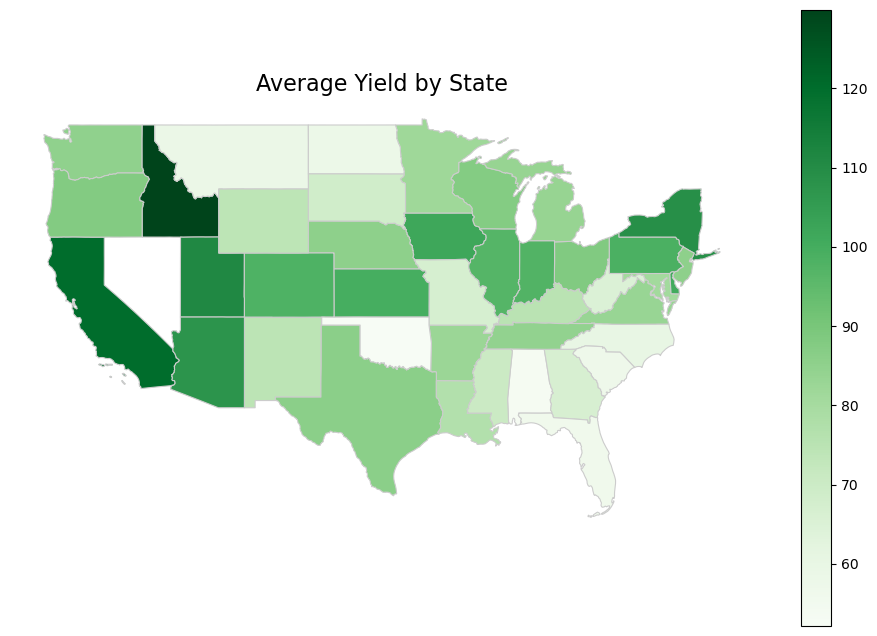

In [16]:
# Load US state shapefile
states = gpd.read_file("cb_2018_us_state_20m.zip")

# Ensure consistent casing for merge
states['NAME'] = states['NAME'].str.upper()
state_avg_yield['state_name'] = state_avg_yield['state_name'].str.upper()

# Merging data
merged = states.merge(state_avg_yield, left_on='NAME', right_on='state_name')

# Plotting the average yield by state
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Yield', cmap='Greens', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
ax.set_title('Average Yield by State', fontsize=16)
ax.axis('off')
plt.show()

In [17]:
# Looking at the stats of the yield values
df['Yield'].describe()

count    221557.000000
mean         81.044844
std          48.957053
min           0.000000
25%          40.000000
50%          73.600000
75%         114.600000
max         296.300000
Name: Yield, dtype: float64

Quite large std, indicating high variability of yield and a quarter of the data is below this value

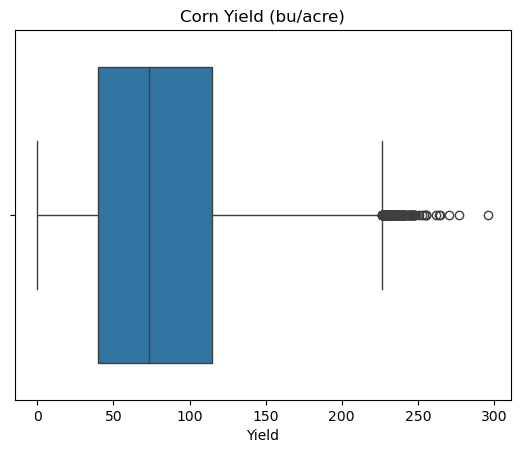

In [18]:
# Visualizing the distribution of corn yield values
sns.boxplot(df['Yield'], orient='h')
plt.title('Corn Yield (bu/acre)')
plt.show()

The majority of yields are clustered below 150 bu/acre, with a concentration in the 50–100 range <br>
There’s a long tail of exceptional yields, likely from regions or years with optimal conditions

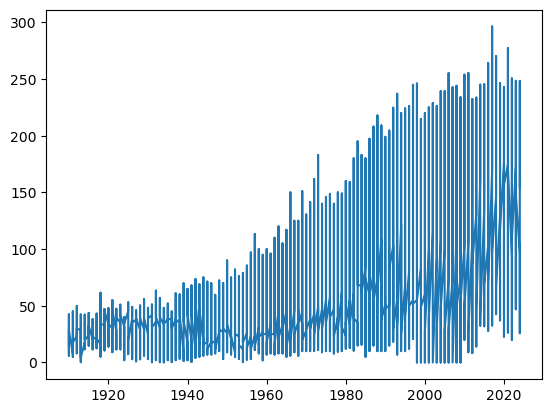

In [19]:
plt.plot(df['year'], df['Yield'])
plt.show()

From 1920 to 2020 there has been a sharp increase in yield values, suggesting steady growth. Probably a sign of improved productivity due to technology. <br>
It is interesting to note that since 1960 the values have begun to rise more rapidly, most likely due to significant advances in hybrid crops. <br>
It is also possible to see that there are significant declines and peaks, most likely related to weather conditions or other global events.

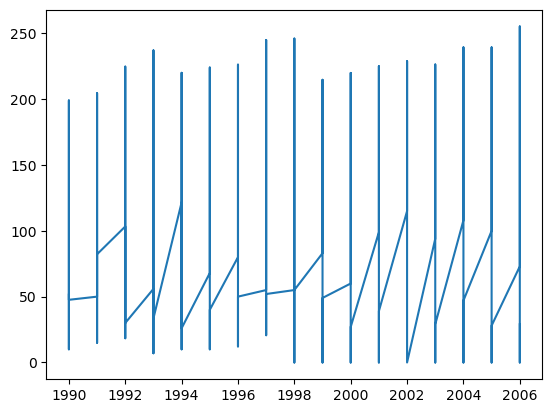

In [20]:
df_filtered = df[(df['year'] >= 1990) & (df['year'] <= 2006)]
plt.plot(df_filtered['year'], df_filtered['Yield'])
plt.show()


In particular, between approximately 1990 and 2006, there were several locations with very low yields.

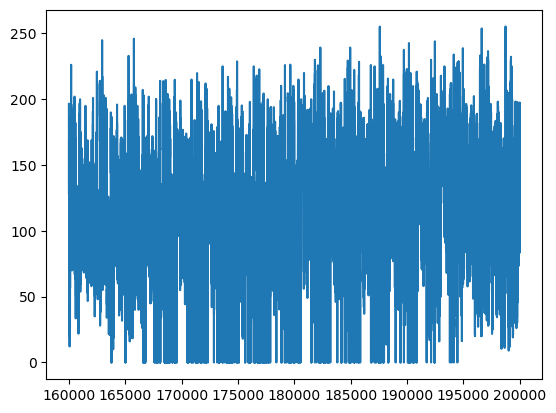

In [21]:
plt.plot(df['Yield'].loc[160000:200000])
plt.show()

In [22]:
# Setting the index to 'year' for time series analysis for average yield
ts = year_mean.set_index('year')
ts_yield = pd.Series(ts['Yield'])

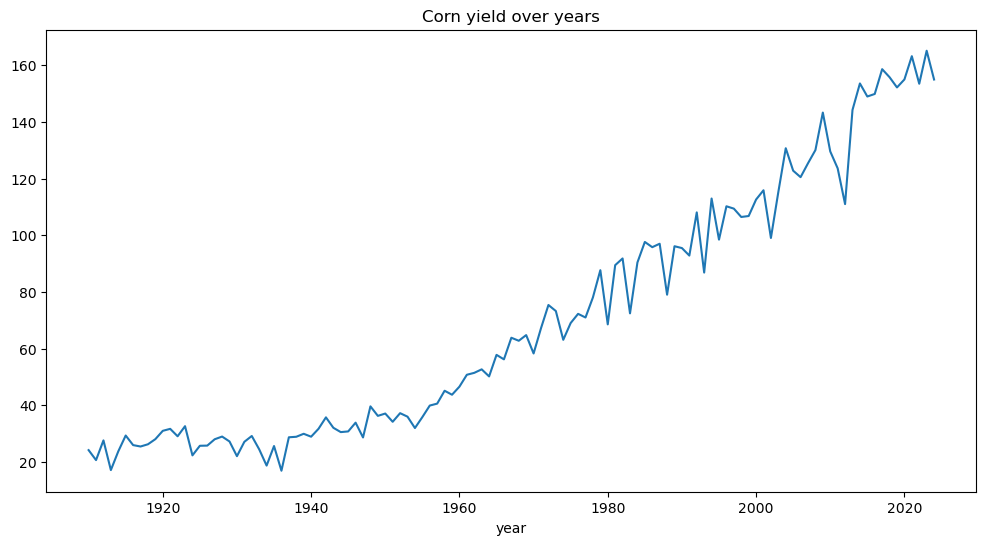

In [23]:
ts_yield.plot(legend=False, title='Corn yield over years', figsize=(12, 6))
plt.show()

In [24]:
# Calculating the average yield for each state
state_means = year_state_mean.groupby('state_name')['Yield'].mean()
# Finding the states with the highest and lowest average yield
top_state = state_means.idxmax()
bottom_state = state_means.idxmin()

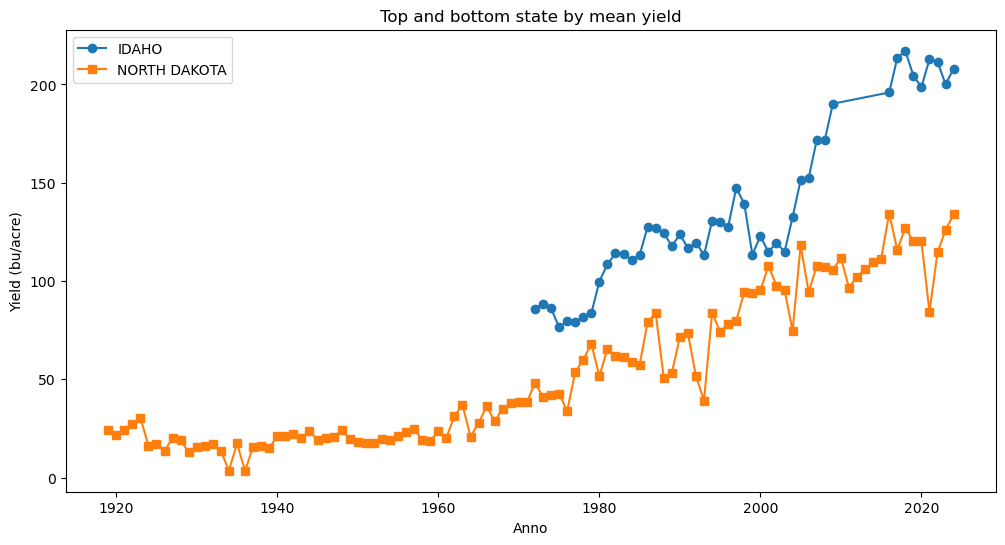

In [25]:
# Plotting the top and bottom states by mean yield
top_data = year_state_mean[year_state_mean['state_name'] == top_state]
bottom_data = year_state_mean[year_state_mean['state_name'] == bottom_state]

plt.figure(figsize=(12, 6))
plt.plot(top_data['year'], top_data['Yield'], marker='o', label=top_state)
plt.plot(bottom_data['year'], bottom_data['Yield'], marker='s', label=bottom_state)

plt.title("Top and bottom state by mean yield")
plt.xlabel("Anno")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()


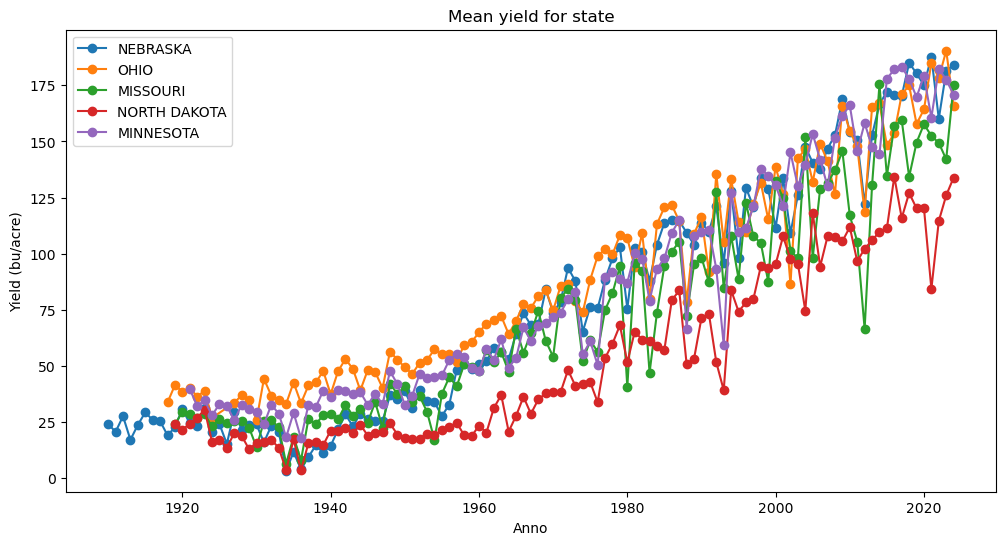

In [26]:
# Graph for the firts 10 states
states_to_plot = year_state_mean['state_name'].unique()[:5]  

plt.figure(figsize=(12, 6))
for state in states_to_plot:
    data = year_state_mean[year_state_mean['state_name'] == state]
    plt.plot(data['year'], data['Yield'], marker='o', label=state)

plt.title("Mean yield for state")
plt.xlabel("Anno")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()

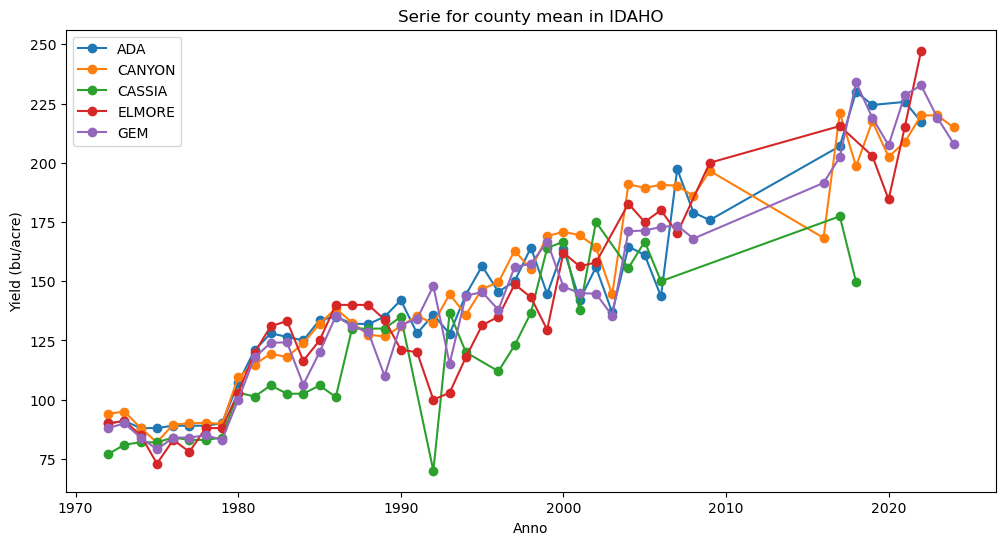

In [27]:
# Serie for county in a specific state
state_example = 'IDAHO'
county_time_series = df[df['state_name'] == state_example].groupby(['year', 'county_name'])['Yield'].mean().reset_index()

# Selezioniamo alcuni county per il grafico (massimo 5)
counties_to_plot = county_time_series['county_name'].unique()[:5]

plt.figure(figsize=(12, 6))
for county in counties_to_plot:
    data = county_time_series[county_time_series['county_name'] == county]
    plt.plot(data['year'], data['Yield'], marker='o', label=county)

plt.title(f"Serie for county mean in {state_example}")
plt.xlabel("Anno")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()

In earlier years (1970-80), the counties' values are close together, but all counties show a clear increasing trend in the variable over the decades. <br>
Around 1991, CASSIA shows a sharp drop and around 2022, ELMORE spikes to nearly 250, higher than others. There seems to be also a gap between 2010 and 2016.

In [28]:
# checking for the gap
df[df['state_name']== 'IDAHO'].groupby(['year', 'county_name'])['Yield'].mean().reset_index()['year'].unique()

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024])

### Weather Data

In [29]:
# Reading the weather data
hist_wx_df = pd.read_parquet('hist_wx_df.parquet')

In [30]:
# Displaying the first few rows of the weather data
hist_wx_df.head()

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name
0,USA.14.100_1,2000-01-01,9.146448,-0.300685,0.000000,0.333584,0.316295,Will,Illinois
1,USA.14.100_1,2000-01-02,16.077440,4.774050,0.000000,0.343324,0.317686,Will,Illinois
2,USA.14.100_1,2000-01-03,9.560367,1.645247,0.466668,0.342535,0.320476,Will,Illinois
3,USA.14.100_1,2000-01-04,3.089767,-3.193717,1.183839,0.379731,0.338481,Will,Illinois
4,USA.14.100_1,2000-01-05,-1.597997,-8.902274,0.000000,0.353221,0.343165,Will,Illinois


In [ ]:
# Displaying basic statistics of the weather data
hist_wx_df.describe().round(2)

A solid standard deviation for temperature indicate noticeable variation across regions or seasons, extreme rainfall events do exist (max of 224.63)

In [ ]:
# Checking for missing values in the weather data
hist_wx_df.isnull().sum()

aoi_id       0
date         0
tmax         0
tmin         0
precip       0
swvl1        0
swvl2        0
adm2_name    0
adm1_name    0
dtype: int64

<Axes: xlabel='tmax'>

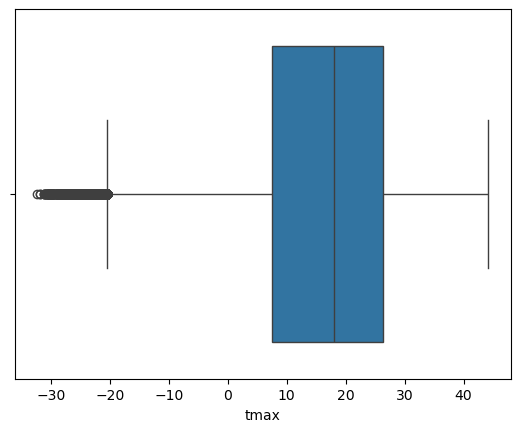

In [ ]:
# Boxplot for temperature max
sns.boxplot(hist_wx_df['tmax'], orient='h')

A long tail towards very low values (outliers), which could represent measurement errors, <br>
anomalous data, or possibly extreme weather conditions. <br>
I would expect these values in winter, I checked: 

In [ ]:
extr_temp = hist_wx_df[hist_wx_df['tmax'] < -20]
extr_temp = extr_temp.copy()

In [ ]:
# adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())


month
1     3436
2      882
3       21
12    1610
Name: count, dtype: int64


All the extreme events are in winter

[]

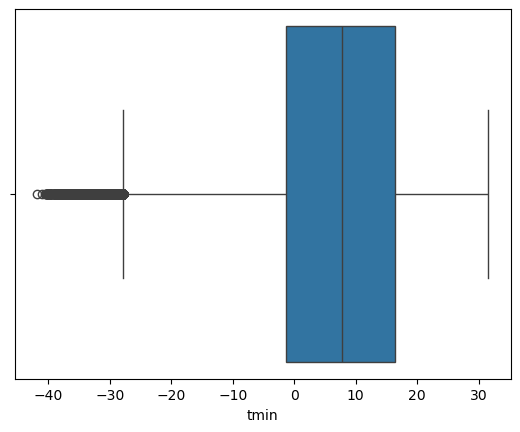

In [ ]:
# Checking also for temperature min
sns.boxplot(hist_wx_df['tmin'], orient='h')
plt.plot()

In [ ]:
extr_temp = hist_wx_df[hist_wx_df['tmin'] < -20]
extr_temp = extr_temp.copy()

# adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())

month
1     52983
2     39579
3      5269
4         4
10        8
11      242
12    23178
Name: count, dtype: int64


In this case too, low temperatures were recorded in winter, apart from four in April, which is plausible given the spring frosts.

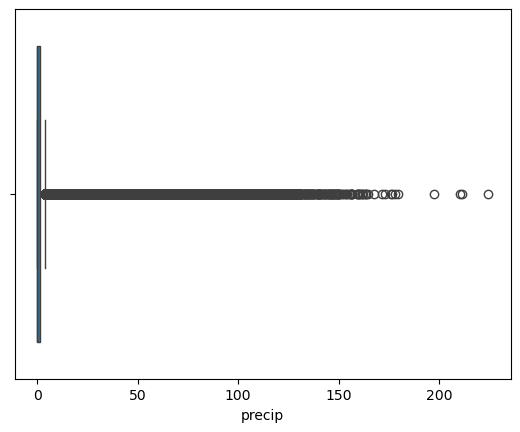

In [ ]:
# Boxplot for precipitation
sns.boxplot(hist_wx_df['precip'], orient='h')
plt.show()

The box plot show clearly highlights a common problem in precipitation data, <br>
the presence of very high outliers and a strongly asymmetrical (skewed) distribution because there a lot of days without rain. <br>
There are several values at the limit, but it is probably an example of extreme weather behaviour, which could be useful for climate modelling or trend analysis.

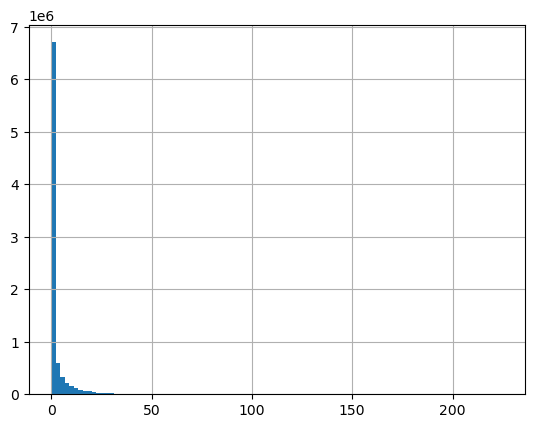

In [ ]:
hist_wx_df['precip'].hist(bins=100)
plt.show()

## Weather events

In [32]:
# Ensure datetime format
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])
hist_wx_df['year'] = hist_wx_df['date'].dt.year
hist_wx_df['month'] = hist_wx_df['date'].dt.month

# Filter for growing season (April to October)
growing_season_df = hist_wx_df[hist_wx_df['month'].between(4, 10)]

# Aggregate weather by year
year_weather_summary = growing_season_df.groupby(
    ['year'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

# Aggregate weather by year and state
year_state_weather_summary = growing_season_df.groupby(
    ['year', 'adm1_name'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum_mean=('precip', 'mean'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [ ]:
year_state_weather_summary.head()

,year,adm1_name,tmax_mean,tmin_mean,precip_sum_mean,swvl1_mean,swvl2_mean
0,2000,Illinois,24.604442,15.020123,3.093348,0.336009,0.335322
1,2000,Indiana,23.362436,13.952075,3.257541,0.336135,0.337944
2,2000,Iowa,23.715995,13.574263,2.508588,0.285794,0.277163
3,2000,Kansas,27.664892,16.325456,2.117374,0.235809,0.234743
4,2000,Kentucky,25.978824,16.301462,2.769042,0.359820,0.363367


In [ ]:
year_weather_summary.head()

,year,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,24.062811,14.027172,528880.740294,0.301953,0.299196
1,2001,23.833894,13.948437,594234.426030,0.311481,0.310350
2,2002,23.728914,13.847579,550877.451700,0.296724,0.292790
3,2003,23.465538,13.276669,548412.235936,0.302949,0.302303
4,2004,23.296945,13.535197,608889.084359,0.309207,0.307541


In [ ]:
# Merge the dataframes of weather and state mean yield
year_state_weather_summary['adm1_name'] = year_state_weather_summary['adm1_name'].str.upper()

yield_weather_state = year_state_mean.merge(
    year_state_weather_summary,
    how='inner',
    left_on=['year', 'state_name'],
    right_on=['year', 'adm1_name']
)

In [ ]:
# Calculate additional features
yield_weather_state['soil_moisture_delta'] = yield_weather_state['swvl1_mean'] - yield_weather_state['swvl2_mean']
yield_weather_state['term_stress'] = yield_weather_state['tmax_mean'] - yield_weather_state['tmin_mean']
yield_weather_state['dry_heat_index'] = (yield_weather_state['tmax_mean']) / (yield_weather_state['precip_sum_mean'] + 1) # adding one to avoid zero div 
yield_weather_state['tmax_mean_lag1'] = yield_weather_state['tmax_mean'].shift(1)
yield_weather_state['precip_sum_lag1'] = yield_weather_state['precip_sum_mean'].shift(1)
yield_weather_state['tmax_mean_3yr'] = yield_weather_state['tmax_mean'].rolling(window=3).mean()
yield_weather_state['precip_sum_3yr'] = yield_weather_state['precip_sum_mean'].rolling(window=3).mean()

In [ ]:
yield_weather_state.columns

Index(['year', 'state_name', 'Yield', 'adm1_name', 'tmax_mean', 'tmin_mean',
       'precip_sum_mean', 'swvl1_mean', 'swvl2_mean', 'soil_moisture_delta',
       'term_stress', 'dry_heat_index', 'tmax_mean_lag1', 'precip_sum_lag1',
       'tmax_mean_3yr', 'precip_sum_3yr'],
      dtype='object')

In [ ]:
# Variabili climatiche da correlare con la resa
features = yield_weather_state.columns.drop(['year', 'state_name', 'adm1_name'])

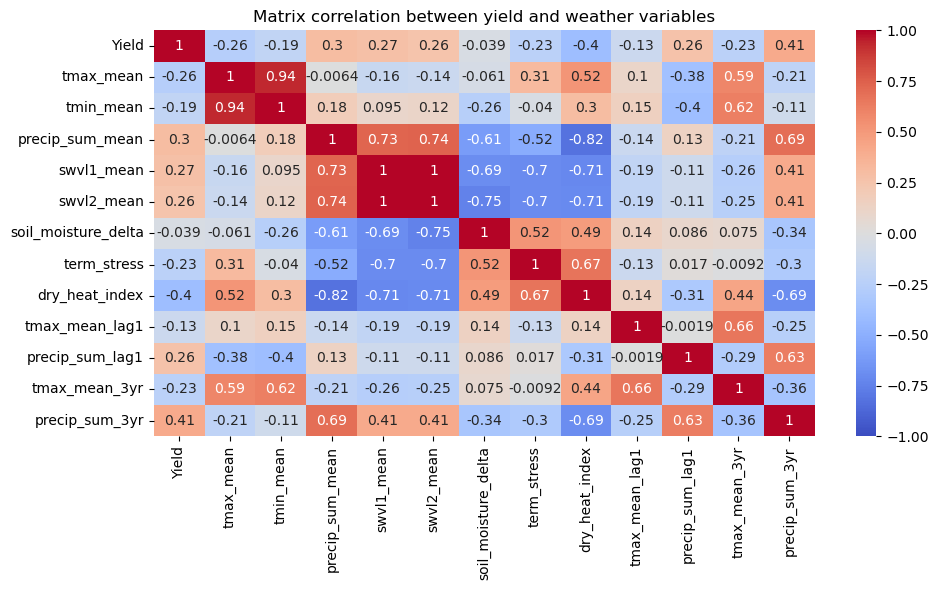

In [ ]:
# Calculating the correlation matrix for the features
corr_matrix = yield_weather_state[features].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrix correlation between yield and weather variables")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate additional features for the year weather summary
year_weather_summary['soil_moisture_delta'] = year_weather_summary['swvl1_mean'] - year_weather_summary['swvl2_mean']
year_weather_summary['term_stress'] = year_weather_summary['tmax_mean'] - year_weather_summary['tmin_mean']
year_weather_summary['dry_heat_index'] = (year_weather_summary['tmax_mean']) / (year_weather_summary['precip_sum'] + 1) # adding one to avoid zero div
year_weather_summary['tmax_mean_lag1'] = year_weather_summary['tmax_mean'].shift(1)
year_weather_summary['precip_sum_lag1'] = year_weather_summary['precip_sum'].shift(1)
year_weather_summary['tmax_mean_3yr'] = year_weather_summary['tmax_mean'].rolling(window=3).mean()
year_weather_summary['precip_sum_3yr'] = year_weather_summary['precip_sum'].rolling(window=3).mean()

In [ ]:
weather_before_2024 = year_weather_summary[:-1] # Removing 2024 since the data is not complete

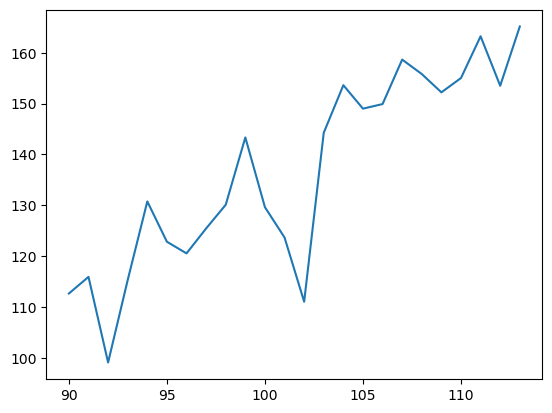

In [ ]:
year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)]['Yield'].plot() # plotting the yield from 2000 to 2023
plt.show()

<Axes: >

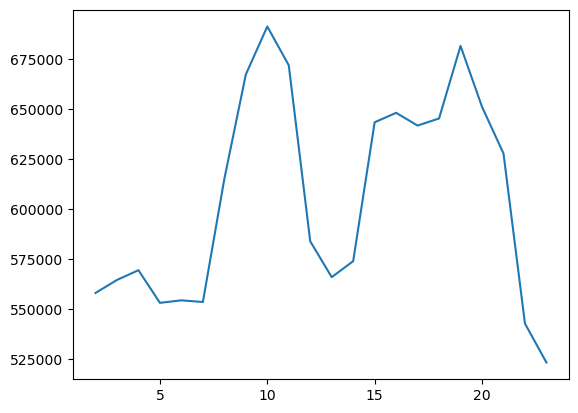

In [ ]:
weather_before_2024['precip_sum_3yr'].plot()

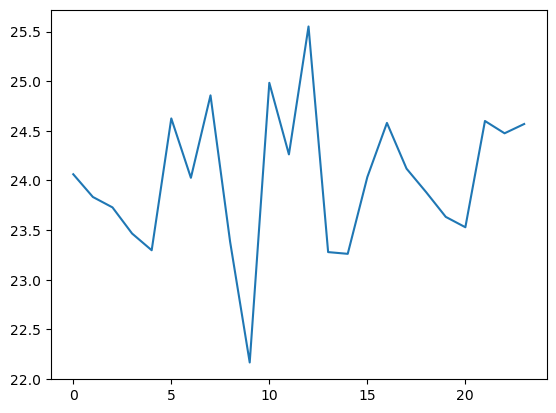

In [ ]:
weather_before_2024['tmax_mean'].plot()
plt.show()

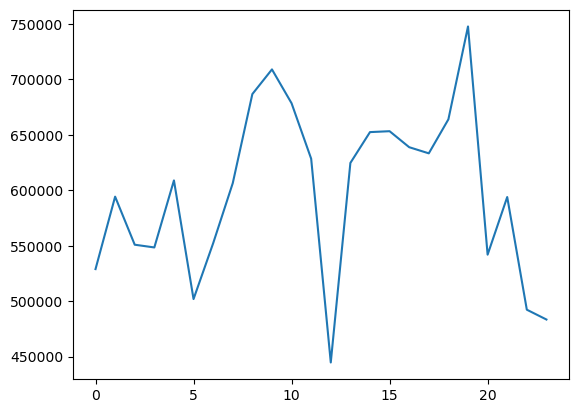

In [ ]:
weather_before_2024['precip_sum'].plot()
plt.show()

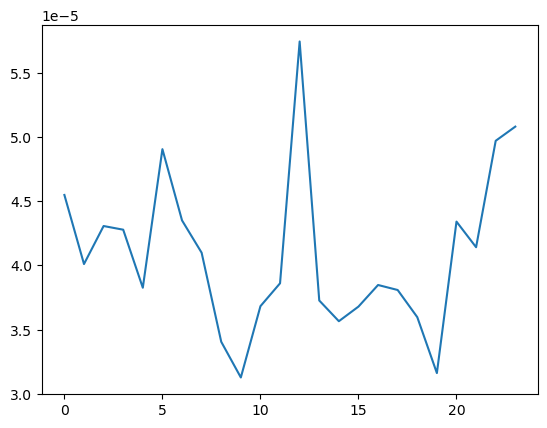

In [ ]:
weather_before_2024['dry_heat_index'].plot()
plt.show()

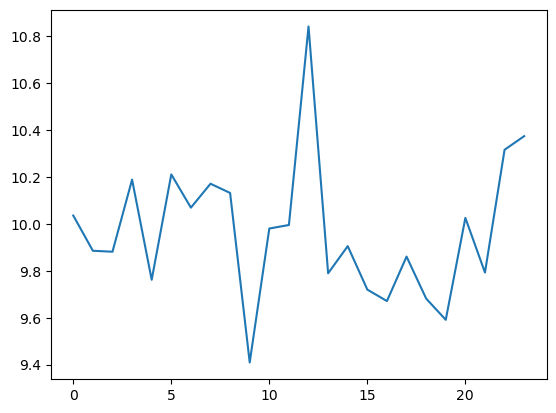

In [ ]:
weather_before_2024['term_stress'].plot()
plt.show()

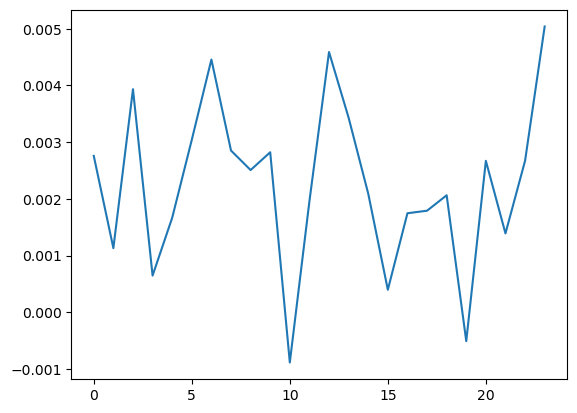

In [ ]:
weather_before_2024['soil_moisture_delta'].plot()
plt.show()

By closely analysing the weather data and yield for the period 2000-2023 (range provided for weather data), several things can be noted: <br>
- A sharp decrease in yield around 2012;<br>
- The decrease in yield coincides with a drastic drop in total rainfall; <br>
- Predictably, in addition to the decrease in rainfall, soil moisture also decreased. <br>
- During the same period, it can be observed that the average maximum temperatures were the highest (drought). <br>
- Average maximum temperatures around 25 degrees, combined with good rainfall/soil moisture, allowed for the best yields. <br>

Corn yield shows a positive relationship with water availability (rain and soil moisture) and a negative relationship with high temperatures, especially maximum temperatures.  <br>
This suggests that crops respond well to a temperate and humid climate, while excessive heat can penalise them, a classic effect of heat stress.

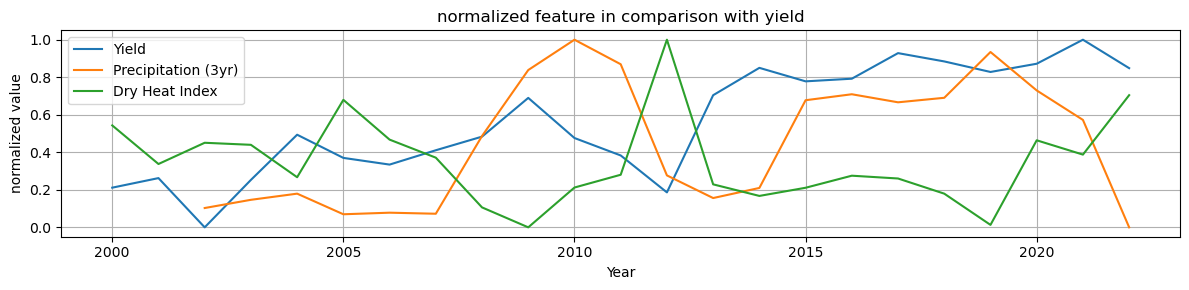

In [ ]:
# Filter the first series between 2000 and 2023
filtered_value = year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)][['year', 'Yield']].copy()

# Extract the other two series
precip = year_weather_summary[['year', 'precip_sum_3yr']].copy()
dry_heat_index = year_weather_summary[['year', 'dry_heat_index']].copy()

# Merge all series on 'year'
merged = filtered_value.merge(precip, on='year').merge(dry_heat_index, on='year')

# Normalize all value columns
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(merged[['Yield', 'precip_sum_3yr', 'dry_heat_index']])
normalized_df = pd.DataFrame(normalized_data, columns=['Yield', 'Precipitation (3yr)', 'Dry Heat Index'])
normalized_df['Year'] = merged['year']

# Plot the normalized series
plt.figure(figsize=(12, 3))
plt.plot(normalized_df['Year'], normalized_df['Yield'], label='Yield')
plt.plot(normalized_df['Year'], normalized_df['Precipitation (3yr)'], label='Precipitation (3yr)')
plt.plot(normalized_df['Year'], normalized_df['Dry Heat Index'], label='Dry Heat Index')
plt.xlabel('Year')
plt.ylabel('normalized value')
plt.title('normalized feature in comparison with yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Prediction

In [ ]:
import warnings
warnings.filterwarnings("ignore")

I applied a simple ARIMA model using only the historical yield data from 1910 for baseline forecasting, and also experimented with ARIMA incorporating weather features from 2000 onward. 

In [ ]:
# Cretating a time series for the average yield per year
ts = year_mean[['Yield']]

print(ts.head())

          Yield
year           
1910  24.149462
1911  20.627957
1912  27.587097
1913  17.106452
1914  23.718280


In [ ]:
ts = ts[:-1]  # Removing the last year (2024)

In [ ]:
ts_yield.isna().sum()

np.int64(0)

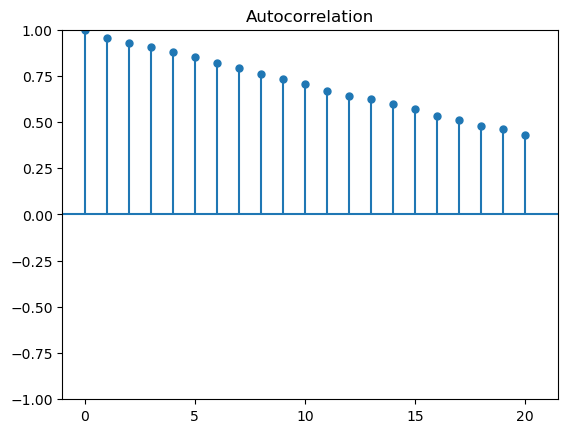

In [ ]:
# Autocorrelation plot for the yield time series
plot_acf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

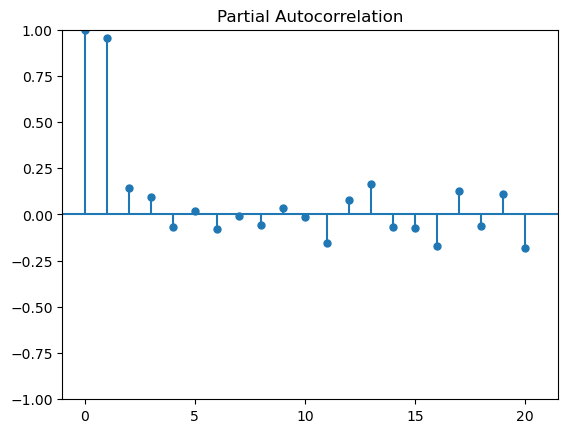

In [ ]:
# Partial autocorrelation plot for the yield time series
plot_pacf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

In [ ]:
# Test Dickey-Fuller for stationarity
result = adfuller(ts['Yield'])
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary
if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary, differencing is needed")


p-value: 0.9990633968161201
The series is not stationary, differencing is needed


In [ ]:
# Find the optimal parameters for ARIMA automatically, settind d=None to let auto_arima decide the differencing order
model = auto_arima(ts['Yield'], seasonal=False, stepwise=True, trace=True, verbose=False, d=None)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=771.042, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=814.185, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=791.207, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=772.541, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=814.474, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=767.951, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=774.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=774.399, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=769.380, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=774.230, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=775.161, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=767.941, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=788.831, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=789.084, 

The selected model has the lowest AIC among all candidates, indicating it balances fit and complexity well. <br>
All estimated parameters (intercept, MA term, and variance) are statistically significant (p-values < 0.05), suggesting they meaningfully contribute to the model.

In [ ]:
# Selecting the best model based on the auto_arima results (differencing internally)
best_model = ARIMA(ts['Yield'], order=model.order)
best_model_fit = best_model.fit()

# Showing the summary of the best model
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Yield   No. Observations:                  114
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -379.970
Date:                Thu, 31 Jul 2025   AIC                            767.941
Time:                        11:30:09   BIC                            778.851
Sample:                             0   HQIC                           772.368
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9935      0.014     68.556      0.000       0.965       1.022
ma.L1         -1.8038      0.067    -26.941      0.000      -1.935      -1.673
ma.L2          0.8315      0.066     12.509      0.0

The model is statistically valid and captures the main dynamics of the series. <br>
Strong evidence of non-constant variance (heteroskedasticity) may affect forecast reliability

In [ ]:
# Lets try to predict the yield for 2024
forecast = best_model_fit.forecast(steps=1)

# Result of the forecast
print(f"Forecasted yield for 2024: {forecast.iloc[0]}")


Forecasted yield for 2024: 166.44938035886162


It is possible to insert also the weather data, of course since we have data from 2000 the data is a lot less but let's give it a try

In [ ]:
# Select the time series from 2000 to 2023
ts = ts[ts.index > 1999]

In [ ]:
interested_features = year_weather_summary.columns.drop(['year','tmax_mean_lag1', 'precip_sum_lag1', 'tmax_mean_3yr', 'precip_sum_3yr'])

In [ ]:
interested_features

Index(['tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean',
       'soil_moisture_delta', 'term_stress', 'dry_heat_index'],
      dtype='object')

In [ ]:
# Adding weather data to the time series
X = year_weather_summary[interested_features]

In [ ]:
X.index = pd.Index(range(2000, 2024), name='year')


In [ ]:
X.index == ts.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

ARIMA or SARIMAX are scale-invariant so it is not important to normalize the X matrix

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Creazione del modello ARIMAX (esogene)
model_arimax = ARIMA(ts['Yield'], exog=X, order=(1, 1, 2))
model_arimax_fit = model_arimax.fit()

# Riassunto del modello
print(model_arimax_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Yield   No. Observations:                   24
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -80.407
Date:                Thu, 31 Jul 2025   AIC                            184.814
Time:                        12:09:39   BIC                            198.440
Sample:                             0   HQIC                           188.241
                                 - 24                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
tmax_mean              -2.6126      2.896     -0.902      0.367      -8.288       3.062
tmin_mean               1.6003      4.447      0.360      0.719      -7.115      10.316
precip_sum      

In [ ]:
X_2024 = year_weather_summary.loc[year_weather_summary['year'] == 2024]

In [ ]:
X_2024 = X_2024[interested_features]

In [ ]:
# Prevision for 2024
forecast_2024 = model_arimax_fit.forecast(steps=1, exog=X_2024)

# Output
print(f"Yield estimation 2024: {forecast_2024}")

Yield estimation 2024: 2024    67.428269
dtype: float64


As expected, due to the limited number of data points, the model is understandably less efficient and not reliable.

## Prediction Models

We now that USDA yield data is available annually at the county level from 1910 but weather data is available daily at the county level starting from 2000. <br>
To ensure consistency, I chose to use data from 2000 to 2023, where both datasets overlap and can be aggregated to the same spatial and temporal resolution.

In [43]:
# Grouping the yield data by county and year to get the average yield
county_yield = df.groupby(['county_name', 'year'])['Yield'].mean().reset_index()

In [45]:
# Group by county and year, then aggregate
weather_year_county_agg = hist_wx_df.groupby(['adm2_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',  
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

In [46]:
# Now we can add the weather features as we did for state to the county yield data
weather_year_county_agg['soil_moisture_delta'] = weather_year_county_agg['swvl1'] - weather_year_county_agg['swvl2']
weather_year_county_agg['term_stress'] = weather_year_county_agg['tmax'] - weather_year_county_agg['tmin']
weather_year_county_agg['dry_heat_index'] = (weather_year_county_agg['tmax']) / (weather_year_county_agg['precip'] + 1) # adding one to avoid zero div
weather_year_county_agg['tmax_mean_lag1'] = weather_year_county_agg['tmax'].shift(1)
weather_year_county_agg['precip_sum_lag1'] = weather_year_county_agg['precip'].shift(1)
weather_year_county_agg['tmax_mean_3yr'] = weather_year_county_agg['tmax'].rolling(window=3).mean()
weather_year_county_agg['precip_sum_3yr'] = weather_year_county_agg['precip'].rolling(window=3).mean()

In [47]:
# Fit the names to merge with county_yield
weather_year_county_agg['adm2_name'] = weather_year_county_agg['adm2_name'].str.upper()  

# Merging the weather data with the county yield data
df_county = weather_year_county_agg.merge(county_yield, left_on=['adm2_name', 'year'], right_on=['county_name', 'year'], how='inner')

# Dropping the 'adm2_name' column as it is not needed anymore
df_county.drop(columns=['adm2_name'], inplace=True)

In [48]:
df_county.columns

Index(['year', 'tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'soil_moisture_delta', 'term_stress', 'dry_heat_index',
       'tmax_mean_lag1', 'precip_sum_lag1', 'tmax_mean_3yr', 'precip_sum_3yr',
       'county_name', 'Yield'],
      dtype='object')

In [49]:
df_county = df_county[df_county['year'] != 2024]  # Exclude year 2024 from the main dataset

### Data preprocessing

In [50]:
# Load the data
data = df_county

# Handle missing values and categorical columns
X = data.drop(columns=['Yield'])
y = data['Yield']

# List categorical columns to be one-hot encoded or label encoded
categorical_columns = ['county_name', 'year']  

# List continuous columns to be scaled
numerical_columns = df_county.columns.drop(['county_name', 'year', 'Yield'])  

# Create the preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical data
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Combine pipelines into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)


In [51]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create the input for the model

Since the 2024 weather data is not completly available, I used the mean values from the weather dataset. <br>
We can look at the performance and if not completely satisfied we could think about the prediction also for weather missing data, <br>
but predicting weather introduces modeling complexity and potential noise while using the historical mean provides a fast, stable, unbiased estimate that doesn’t risk overfitting.

In [71]:
# Group by county then aggregate for the mean 
year_2024 = hist_wx_df.groupby(['adm2_name']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',   
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

# Adding the year column for the model
year_2024['year'] = 2024  
year_2024.rename(columns={'adm2_name': 'county_name'}, inplace=True)

# Calculate additional features for the year 2024
year_2024['soil_moisture_delta'] = year_2024['swvl1'] - year_2024['swvl2']
year_2024['term_stress'] = year_2024['tmax'] - year_2024['tmin']
year_2024['dry_heat_index'] = (year_2024['tmax']) / (year_2024['precip'] + 1) 
year_2024['tmax_mean_lag1'] = year_2024['tmax'].shift(1)
year_2024['precip_sum_lag1'] = year_2024['precip'].shift(1)
year_2024['tmax_mean_3yr'] = year_2024['tmax'].rolling(window=3).mean()
year_2024['precip_sum_3yr'] = year_2024['precip'].rolling(window=3).mean()

### Linear Regression
Linear Regression is a simple, assumes a linear relationship between the input features and the target variables.

In [99]:
# Preprocess training data
X_design = preprocessor.fit_transform(X_train)

# Convert to dense array if it's sparse
if hasattr(X_design, "toarray"):
    X_design = X_design.toarray()

# Add intercept
X_design = sm.add_constant(X_design)

# Fit statsmodels OLS
ols_model = sm.OLS(y_train, X_design).fit()

# Preprocess 2024 input
X_2024 = preprocessor.transform(year_2024)

# Convert to dense if sparse
if hasattr(X_2024, "toarray"):
    X_2024 = X_2024.toarray()

# Add intercept
X_2024 = sm.add_constant(X_2024)

# Prediction with confidence interval
pred_2024 = ols_model.get_prediction(X_2024)
summary_frame = pred_2024.summary_frame(alpha=0.05)

point = summary_frame["mean"].values[0]
ci_lower = summary_frame["obs_ci_lower"].values[0]
ci_upper = summary_frame["obs_ci_upper"].values[0]

print(f"2024 Prediction (OLS): {point:.2f} bu/acre, 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")


2024 Prediction (OLS): 160.22 bu/acre, 95% CI: [125.96, 194.49]


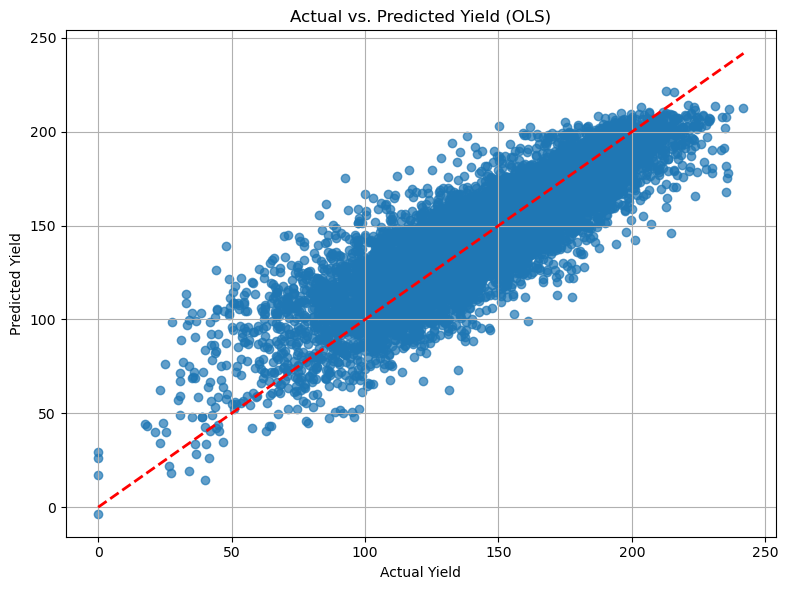

In [ ]:
# Get predictions on training set
y_pred_train = ols_model.predict(X_design)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_train, y_pred_train, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs. Predicted Yield (OLS)")
plt.grid(True)
plt.tight_layout()
plt.show()


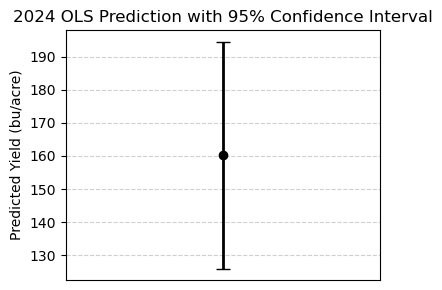

In [ ]:
# Plotting
plt.figure(figsize=(4, 3))
plt.errorbar(x=0, y=point, yerr=[[point - ci_lower], [ci_upper - point]], fmt='o', color='black', capsize=5)
plt.xlim(-1, 1)
plt.xticks([])
plt.ylabel('Predicted Yield (bu/acre)')
plt.title('2024 OLS Prediction with 95% Confidence Interval - Linear Regression')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Random Forest Regressor

In [79]:
# Model pipeline with a Random Forest Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results_random_forest = {
    'MAE': mae,
    'MSE': mse,
    'R²': r2
}

print("=== Random Forest Regression ===")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

=== Random Forest Regression ===
MAE: 15.161484914414249
MSE: 408.86695832488647
R²: 0.6569363755377644


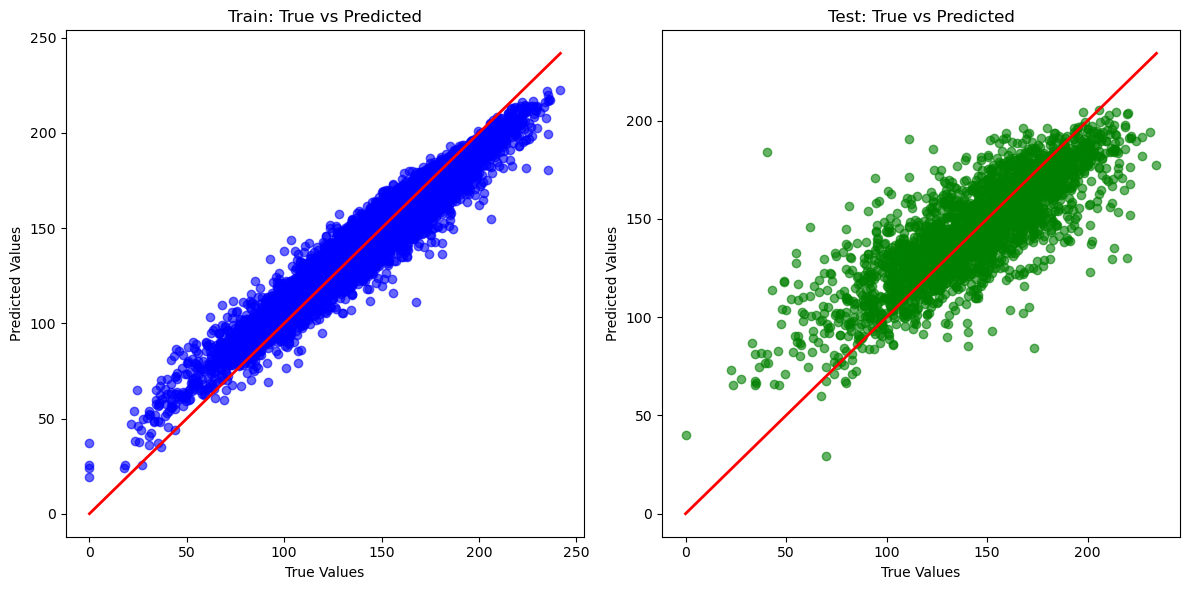

In [92]:
# Predictions for training set
y_train_pred = model_pipeline.predict(X_train)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
plt.title('Train: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Test: True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [80]:
# Fit Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf.fit(X_train, y_train)

# Get prediction from each tree
model = rf.named_steps['model']
X_2024_transformed = rf.named_steps['preprocessor'].transform(year_2024)

tree_preds = np.array([tree.predict(X_2024_transformed) for tree in model.estimators_])
mean_pred = tree_preds.mean()
std_pred = tree_preds.std()

results_random_forest.update({
    'Mean Prediction': mean_pred,
    'Std Prediction': std_pred
})

print(f"2024 Prediction (Random Forest): {mean_pred:.2f} ± {std_pred:.2f} bu/acre")

2024 Prediction (Random Forest): 152.01 ± 31.41 bu/acre


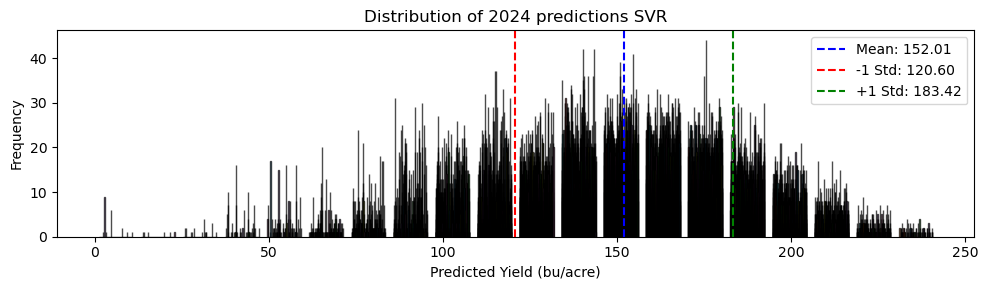

In [81]:
# Plot the distribution of predictions
plt.figure(figsize=(10, 3))
plt.hist(tree_preds, bins=20, edgecolor='black', alpha=0.7)  
plt.axvline(mean_pred, color='blue', linestyle='--', label=f'Mean: {mean_pred:.2f}')
plt.axvline(mean_pred - std_pred, color='red', linestyle='--', label=f'-1 Std: {mean_pred - std_pred:.2f}')
plt.axvline(mean_pred + std_pred, color='green', linestyle='--', label=f'+1 Std: {mean_pred + std_pred:.2f}')
plt.title('Distribution of 2024 predictions SVR')
plt.xlabel('Predicted Yield (bu/acre)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### Support Vector Regression (SVR)
Support Vector Regression (SVR) is a version of Support Vector Machines (SVM) for regression tasks. It works by finding a hyperplane that best fits the data in a high-dimensional space.

In [82]:
# Support Vector Regression
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=100, epsilon=0.1))  
])

# Training
svr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_svr = svr_pipeline.predict(X_test)

results_support_vector_regression = {
    'MAE': mean_absolute_error(y_test, y_pred_svr),
    'MSE': mean_squared_error(y_test, y_pred_svr),
    'R²': r2_score(y_test, y_pred_svr)
}

# Evaluate the SVR model
print("=== Support Vector Regression ===")
print(f"MAE: {results_support_vector_regression['MAE']}")
print(f"MSE: {results_support_vector_regression['MSE']}")
print(f"R²: {results_support_vector_regression['R²']}")


=== Support Vector Regression ===
MAE: 11.773229389274105
MSE: 263.62951704879845
R²: 0.7787992015678499


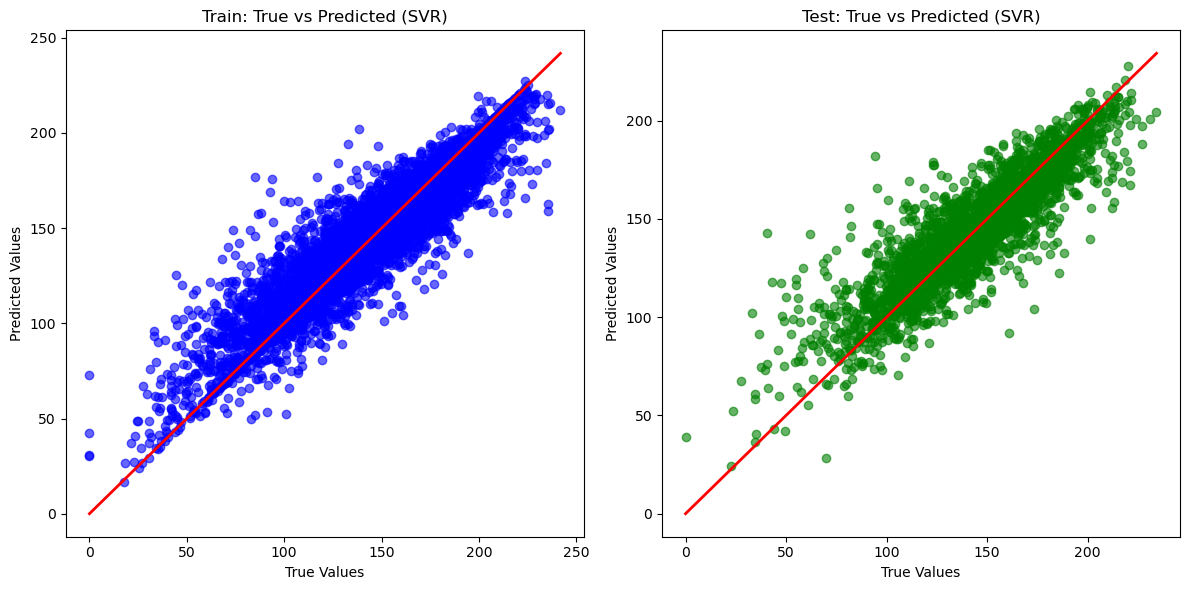

In [93]:
# Predictions for the training set
y_train_pred_svr = svr_pipeline.predict(X_train)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_svr, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
plt.title('Train: True vs Predicted (SVR)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_svr, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Test: True vs Predicted (SVR)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [83]:
# Bootstrap for uncertainty estimation for SVR 
n_bootstraps = 50
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model (use e.g. SVR or ElasticNet)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR())  # or ElasticNet()
    ])
    model.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

results_support_vector_regression.update({
    'Mean Prediction': mean_prediction,
    'Std Prediction': std_prediction
})

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")


2024 Yield Prediction: 156.30 ± 0.97 bu/acre


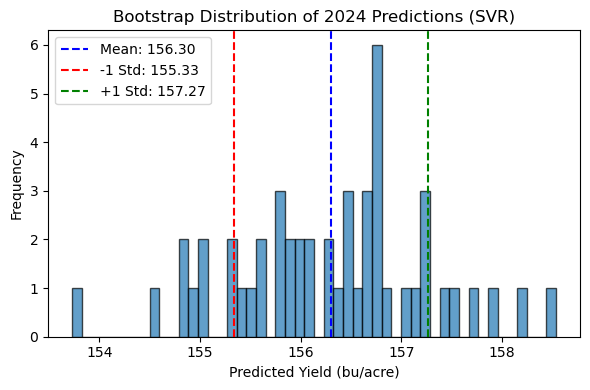

In [84]:
# Plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(predictions, bins=n_bootstraps, edgecolor='black', alpha=0.7)
plt.axvline(mean_prediction, color='blue', linestyle='--', label=f'Mean: {mean_prediction:.2f}')
plt.axvline(mean_prediction - std_prediction, color='red', linestyle='--', label=f'-1 Std: {mean_prediction - std_prediction:.2f}')
plt.axvline(mean_prediction + std_prediction, color='green', linestyle='--', label=f'+1 Std: {mean_prediction + std_prediction:.2f}')
plt.title('Bootstrap Distribution of 2024 Predictions (SVR)')
plt.xlabel('Predicted Yield (bu/acre)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


### ElasticNet (Regularized Linear Model)
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization, which can help improve the model's generalization when there is multicollinearity in the data.

In [85]:
# ElasticNet
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=1000))
])

# Training
elastic_net_pipeline.fit(X_train, y_train)

# Predictions
y_pred_en = elastic_net_pipeline.predict(X_test)

results_elastic_net = {
    'MAE': mean_absolute_error(y_test, y_pred_en),
    'MSE': mean_squared_error(y_test, y_pred_en),
    'R²': r2_score(y_test, y_pred_en)
}

# Evaluation
print("=== ElasticNet Regression ===")
print(f"MAE: {results_elastic_net['MAE']}")
print(f"MSE: {results_elastic_net['MSE']}")
print(f"R²: {results_elastic_net['R²']}")


=== ElasticNet Regression ===
MAE: 14.577742654309121
MSE: 375.22309671061197
R²: 0.6851655705639068


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.574e+05, tolerance: 1.228e+03
  model = cd_fast.sparse_enet_coordinate_descent(


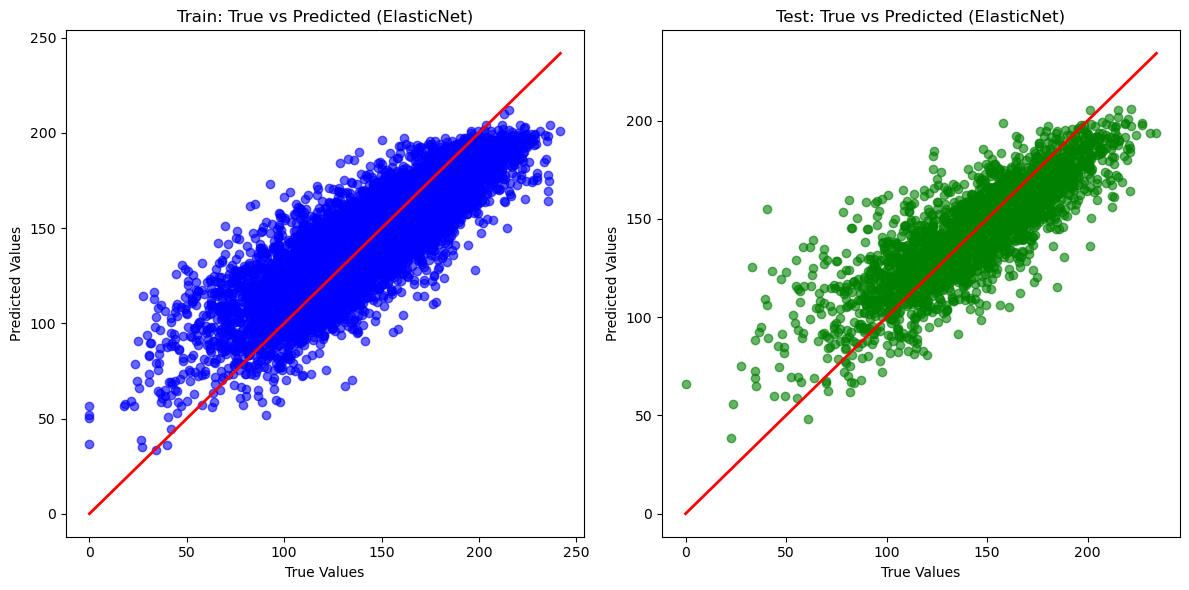

In [96]:
# Predictions for the training set
y_train_elastic_net = elastic_net_pipeline.predict(X_train)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_elastic_net, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
plt.title('Train: True vs Predicted (ElasticNet)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_en, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Test: True vs Predicted (ElasticNet)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [90]:
# Bootstrap for ElasticNet
# Using the same preprocessor and model as before
n_bootstraps = 50
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model 
    model_en = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', ElasticNet())  # or ElasticNet()
    ])
    model_en.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model_en.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

results_elastic_net.update({
    'Mean Prediction': mean_prediction,
    'Std Prediction': std_prediction
})

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")

2024 Yield Prediction: 147.54 ± 0.36 bu/acre


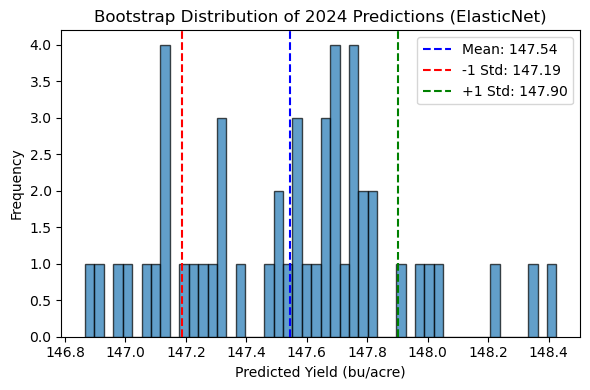

In [91]:
# Plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(predictions, bins=n_bootstraps, edgecolor='black', alpha=0.7)
plt.axvline(mean_prediction, color='blue', linestyle='--', label=f'Mean: {mean_prediction:.2f}')
plt.axvline(mean_prediction - std_prediction, color='red', linestyle='--', label=f'-1 Std: {mean_prediction - std_prediction:.2f}')
plt.axvline(mean_prediction + std_prediction, color='green', linestyle='--', label=f'+1 Std: {mean_prediction + std_prediction:.2f}')
plt.title('Bootstrap Distribution of 2024 Predictions (ElasticNet)')
plt.xlabel('Predicted Yield (bu/acre)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

## Reporting

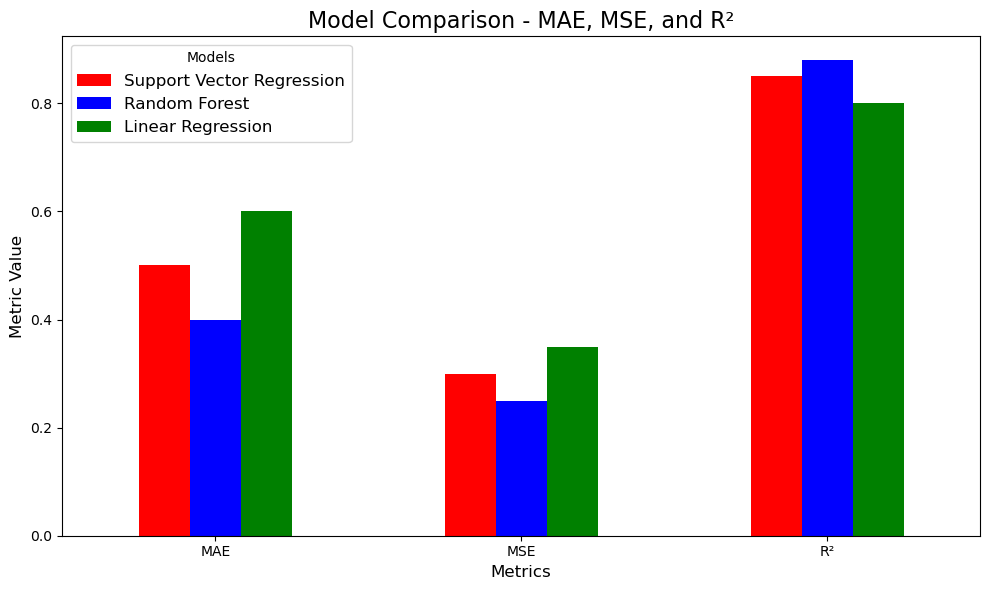

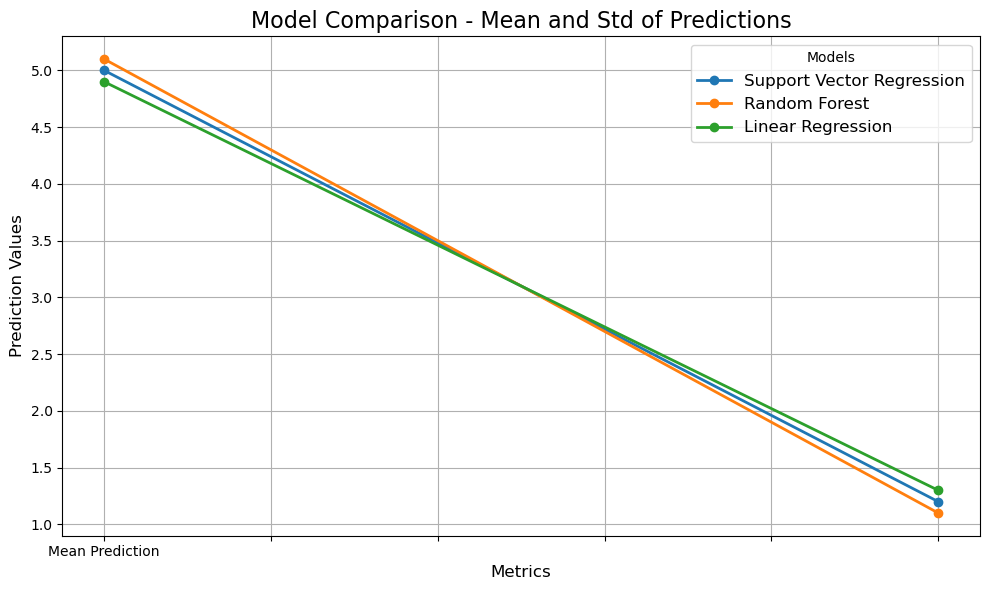

In [ ]:

# Combine the results into a single dictionary
all_results = {
    'Support Vector Regression': results_support_vector_regression,
    'Random Forest': results_random_forest,
    'Linear Regression': results_linear_regression
}

# Convert the dictionary into a DataFrame for easier plotting
import pandas as pd

# Create a DataFrame for metrics comparison
metrics_df = pd.DataFrame({
    model: [results['MAE'], results['MSE'], results['R²']]
    for model, results in all_results.items()
}, index=['MAE', 'MSE', 'R²'])

# Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=ax, color=['red', 'blue', 'green'])
plt.title('Model Comparison - MAE, MSE, and R²', fontsize=16)
plt.ylabel('Metric Value', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Models", fontsize=12)

# Optional: Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='white', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Optional: Add a line plot for 'Mean Prediction' and 'Std Prediction'
prediction_df = pd.DataFrame({
    model: [results['Mean Prediction'], results['Std Prediction']]
    for model, results in all_results.items()
}, index=['Mean Prediction', 'Std Prediction'])

fig, ax = plt.subplots(figsize=(10, 6))
prediction_df.plot(kind='line', marker='o', ax=ax, lw=2)
plt.title('Model Comparison - Mean and Std of Predictions', fontsize=16)
plt.ylabel('Prediction Values', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Models", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
